In [1]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

In [2]:
import pandas as pd
import numpy as np
from bayesian.train_bn import structure_learning, parameter_learning, parameter_learning_mix, n_component
from preprocess.discretization import get_nodes_type, discretization, inverse_discretization, code_categories, get_nodes_sign
from bayesian.save_bn import save_structure, save_params, read_structure, read_params
from bayesian.sampling import generate_synthetics
from external.libpgm.hybayesiannetwork import HyBayesianNetwork
from visualization.visualization import draw_BN
from bayesian.calculate_accuracy import calculate_acc, LOO_validation
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from copy import copy
from external.libpgm.sampleaggregator import SampleAggregator
import operator
from sklearn.metrics import accuracy_score, mean_squared_error
from scipy import stats
from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture
import math
from pomegranate import DiscreteDistribution
import random
from sklearn.model_selection import train_test_split
from gmr import GMM
from bayesian.subsample import get_subsample
from visualization.visualization import get_probability

In [3]:
data = pd.read_csv('../data/geo3_1.csv')
data.head(10)
columns = ['Tectonic regime', 'Period', 'Lithology', 'Structural setting', 'Gross','Netpay','Porosity','Permeability', 'Depth', 'Oil density', 'Oil recovery factor', 'NTG_comb']
data = data[columns]
data.dropna(inplace=True)
data.reset_index(inplace=True, drop=True)

In [4]:
node_type = get_nodes_type(data)
node_type

{'Tectonic regime': 'disc',
 'Period': 'disc',
 'Lithology': 'disc',
 'Structural setting': 'disc',
 'Gross': 'cont',
 'Netpay': 'cont',
 'Porosity': 'cont',
 'Permeability': 'cont',
 'Depth': 'cont',
 'Oil density': 'cont',
 'Oil recovery factor': 'cont',
 'NTG_comb': 'cont'}

In [5]:
geo_signs = get_nodes_sign(data)
geo_signs

{'Gross': 'pos',
 'Netpay': 'pos',
 'Porosity': 'pos',
 'Permeability': 'pos',
 'Depth': 'pos',
 'Oil density': 'pos',
 'Oil recovery factor': 'pos',
 'NTG_comb': 'pos'}

In [6]:
colums_for_code = []
columns_for_disc = []
for c in columns:
    if node_type[c] == 'disc':
        colums_for_code.append(c)
    else:
        columns_for_disc.append(c)

In [8]:
sample_size = [20, 40, 60, 100]#, 40, 60, 80, 100, 120, 200]

In [9]:
accuracy_df = pd.DataFrame(columns = ['Parameter', 'Sample size', 'Accuracy','Method'])
rmse_df = pd.DataFrame(columns = ['Parameter', 'Sample size', 'RMSE','Method'])

In [10]:
data_discrete, est = discretization(data, 'kmeans', columns_for_disc)
data_discrete, code_dict = code_categories(data_discrete, 'label', colums_for_code)

In [11]:
for m in sample_size:
    print(m)
    accuracy_dict = dict()
    rmse_dict = dict()
    pred_param = [[0 for j in range(data.shape[0])] for i in range(len(columns))]
    real_param = [[0 for j in range(data.shape[0])] for i in range(len(columns))]
    for i in range (data.shape[0]):
        test = dict(data.iloc[i,:])
        for n, key in enumerate(columns):
            train_dict = copy(test)
            train_dict.pop(key)
            cluster = get_subsample(train_dict, data, 'hamming', [c for c in columns if c != key], m)
            indexes = cluster.index.to_list()
            train_data = data_discrete.loc[indexes,:]
            train_data.reset_index(inplace=True, drop=True)
            cluster.reset_index(inplace=True, drop=True)
            bn = structure_learning(train_data, 'HC', node_type, 'K2')
            params = parameter_learning(cluster, node_type, bn, 'simple')
            save_structure(bn, 'cluster_net')
            skel = read_structure('cluster_net')
            save_params(params, 'cluster_net_param')
            params = read_params('cluster_net_param')
            cluster_bn = HyBayesianNetwork(skel, params)
            try:
                if node_type[key] == 'disc':
                    agg = SampleAggregator()
                    sample = agg.aggregate(cluster_bn.randomsample(2000, 'simple', train_dict))
                    sorted_res = sorted(sample[key].items(), key=operator.itemgetter(1), reverse=True)
                    pred_param[n][i] = sorted_res[0][0]
                    real_param[n][i] = test[key]
                if node_type[key] == 'cont':
                    sample = pd.DataFrame(cluster_bn.randomsample(2000, 'simple', train_dict))
                    sample = sample.loc[sample[key] >= 0]
                    if sample.shape[0] == 0:
                        print(i)
                    else:
                        pred = np.mean(sample[key].values)
                        pred_param[n][i] = pred
                        real_param[n][i] = test[key]
            except:
                print(i)
    for n, key in enumerate(columns):
        if node_type[key] == 'disc':
            accuracy_dict[key] = round(accuracy_score(real_param[n], pred_param[n]),2)
        if node_type[key] == 'cont':
            rmse_dict[key] = round(mean_squared_error(real_param[n], pred_param[n], squared=False) / (np.max(real_param[n]) - np.min(real_param[n])),2)
    for key in accuracy_dict.keys():
        accuracy_df = accuracy_df.append({'Parameter': key, 'Sample size': m, 'Accuracy': accuracy_dict[key], 'Method':'Hamming'}, ignore_index=True)
    for key in rmse_dict.keys():
        rmse_df = rmse_df.append({'Parameter': key, 'Sample size': m, 'RMSE': rmse_dict[key], 'Method':'Hamming'}, ignore_index=True)

20
2
2
3
4
14
20
22
22
22
31
39
39
39
41
46
46
46
57
57
62
78
78
86
86
86
105
106
106
106
110
123
125
125
126
126
126
127
127
131
131
133
133
136
136
138
138
138
142
142
142
150
150
160
164
170
173
176
176
176
176
176
181
190
190
193
196
196
196
196
200
200
200
202
202
217
217
226
227
227
230
230
239
241
243
265
265
267
267
268
269
269
269
269
271
272
273
277
277
277
285
290
301
302
303
304
305
305
315
315
40
22
22
22
31
39
42
46
46
78
78
86
105
106
106
131
131
133
138
154
170
170
170
176
176
176
181
196
196
200
202
230
230
230
239
239
267
269
269
269
269
271
272
275
277
285
285
304
305
315
315
315
60
22
46
62
78
100
105
105
125
127
131
131
138
164
196
200
229
230
230
239
285
285
285
304
304
315
315
315
100
53
62
66
78
173
227
235
239
277
285
285
285
285
304
315
315
315
315


In [12]:
accuracy_df.to_csv('acc_hamming_size.csv', index=False)
rmse_df.to_csv('rmse_hamming_size.csv', index=False)

In [13]:
acc_cosine = pd.read_csv('acc_cosine_size.csv')
rmse_cosine = pd.read_csv('rmse_cosine_size.csv')

In [33]:
rmse_df

,Parameter,Sample size,RMSE,Method
0,Gross,20,0.13,Hamming
1,Netpay,20,0.14,Hamming
2,Porosity,20,0.15,Hamming
3,Permeability,20,0.12,Hamming
4,Depth,20,0.17,Hamming
5,Oil density,20,0.06,Hamming
6,Oil recovery factor,20,0.32,Hamming
7,NTG_comb,20,0.25,Hamming
8,Gross,40,0.13,Hamming
9,Netpay,40,0.14,Hamming


In [14]:
acc_gower = pd.read_csv('acc_gower_size.csv')
rmse_gower = pd.read_csv('rmse_gower_size.csv')

In [19]:
round(rmse_df.groupby('Sample size')['RMSE'].mean(), 3)

Sample size
20     0.168
40     0.171
60     0.152
100    0.154
Name: RMSE, dtype: float64

In [21]:
round(accuracy_df.groupby('Sample size')['Accuracy'].mean(), 3)

Sample size
20     0.588
40     0.578
60     0.558
100    0.542
Name: Accuracy, dtype: float64

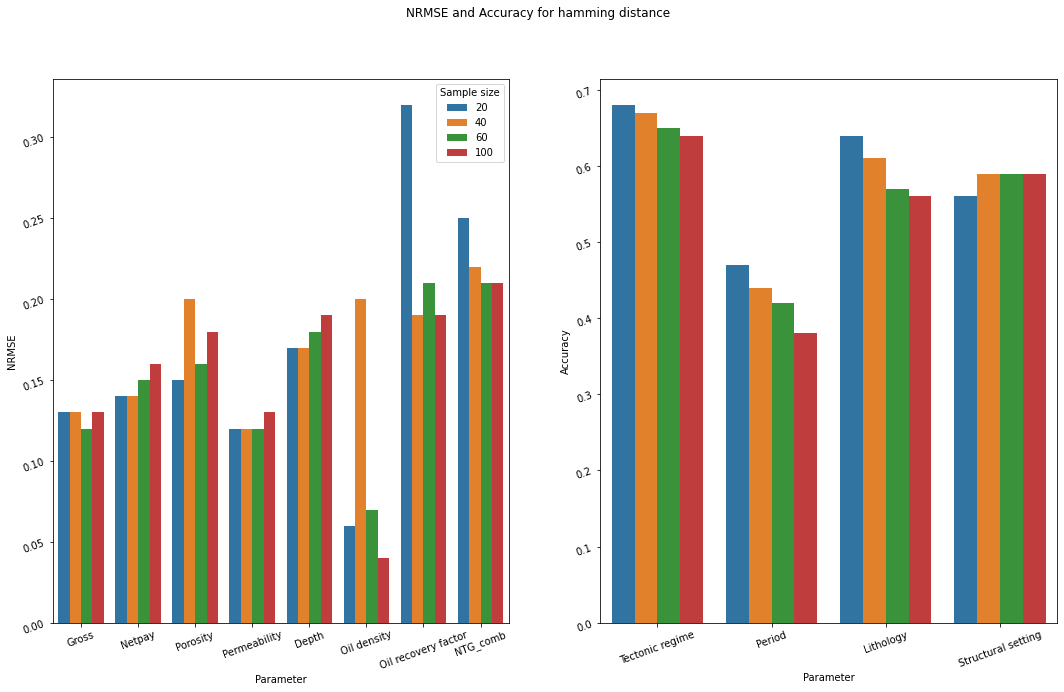

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(18, 10))
fig.suptitle('NRMSE and Accuracy for hamming distance')

# Bulbasaur
sns.barplot(ax=axes[0], x = 'Parameter', y = 'RMSE', hue = 'Sample size', data=rmse_df)
axes[0].set_ylabel('NRMSE')
axes[0].tick_params(labelrotation=20)
sns.barplot(ax=axes[1], x = 'Parameter', y = 'Accuracy', hue = 'Sample size', data=accuracy_df)
axes[1].get_legend().remove()
axes[1].tick_params(labelrotation=20)

In [22]:
geo_coded, label_coder = code_categories(data, 'label', colums_for_code)
geo_discrete, coder = discretization(geo_coded, 'kmeans', columns_for_disc, bins=5)
#geo_only_discrete, discrete_coder = discretization(geo, 'equal_frequency', columns_for_disc)

In [23]:
bn_full = structure_learning(geo_discrete, 'HC', node_type, 'K2')

In [57]:
params = parameter_learning(data, node_type, bn_full, 'simple')
save_structure(bn_full, 'all_net')
skel = read_structure('all_net')
save_params(params, 'all_net_param')
params = read_params('all_net_param')
all_bn = HyBayesianNetwork(skel, params)

In [24]:
acc, rmse, real, pred = LOO_validation(data, geo_discrete, 'simple', columns, 'HC', 'K2')

"['CAMBRIAN-ORDOVICIAN/CARBONIFEROUS']"
"['SILURIAN']"
"['CAMBRIAN']"
"['PERMIAN-TRIASSIC']"
"['PROTEROZOIC-CAMBRIAN']"
"['BASEMENT']"
"['ARCHEAN']"
"['BASEMENT']"
"['SHALY SANDSTONE']"
"['SHALY SANDSTONE']"
"['VOLCANICS']"
"['MESOZOIC']"
"['VOLCANICS']"


In [25]:
acc

{'Tectonic regime': 0.81,
 'Period': 0.32,
 'Lithology': 0.56,
 'Structural setting': 0.41}

In [26]:
rmse

{'Gross': 0.14,
 'Netpay': 0.18,
 'Porosity': 0.21,
 'Permeability': 0.14,
 'Depth': 0.19,
 'Oil density': 0.15,
 'Oil recovery factor': 0.19,
 'NTG_comb': 0.22}

In [27]:
rmse_df

,Parameter,Sample size,RMSE,Method
0,Gross,20,0.13,Hamming
1,Netpay,20,0.14,Hamming
2,Porosity,20,0.15,Hamming
3,Permeability,20,0.12,Hamming
4,Depth,20,0.17,Hamming
5,Oil density,20,0.06,Hamming
6,Oil recovery factor,20,0.32,Hamming
7,NTG_comb,20,0.25,Hamming
8,Gross,40,0.13,Hamming
9,Netpay,40,0.14,Hamming


In [11]:
alg = ['K2', 'MI', 'BIC', 'MI_mixed', 'BIC_mixed']
preproc = ['q_5', 'q_10', 'u_5', 'u_10', 'k_5', 'k_10']

In [12]:
results_rmse = pd.DataFrame(columns=['Discretization', 'Alg', 'Parameter', 'RMSE'])
results_acc = pd.DataFrame(columns=['Discretization', 'Alg', 'Parameter', 'Accuracy'])
edges = dict()
for disc in preproc:
    geo_discrete = []
    bn_full = []
    if disc == 'q_5':
        geo_discrete, coder = discretization(geo_coded, 'equal_frequency', columns_for_disc, bins=5)
    if disc == 'q_10':
        geo_discrete, coder = discretization(geo_coded, 'equal_frequency', columns_for_disc, bins=10)
    if disc == 'u_5':
        geo_discrete, coder = discretization(geo_coded, 'equal_intervals', columns_for_disc, bins=5) 
    if disc == 'u_10':
        geo_discrete, coder = discretization(geo_coded, 'equal_intervals', columns_for_disc, bins=10)
    if disc == 'k_5':
        geo_discrete, coder = discretization(geo_coded, 'kmeans', columns_for_disc, bins=5)
    if disc == 'k_10':
        geo_discrete, coder = discretization(geo_coded, 'kmeans', columns_for_disc, bins=10)
    for learn in alg:
        acc = dict()
        rmse = dict()
        print(disc +' '+learn)
        if learn == 'K2':
            bn_full = structure_learning(geo_discrete, 'HC', geo_types, 'K2')
            acc, rmse, real ,pred = LOO_validation(geo, geo_discrete, 'simple', columns, 'HC', 'K2')
        if learn == 'MI':
            acc, rmse, real ,pred = LOO_validation(geo, geo_discrete, 'simple', columns, 'HC', 'MI')
            bn_full = structure_learning(geo_discrete, 'HC', geo_types, 'MI')
        if learn == 'BIC':
            acc, rmse, real ,pred = LOO_validation(geo, geo_discrete, 'simple', columns, 'HC', 'BIC')
            bn_full = structure_learning(geo_discrete, 'HC', geo_types, 'BIC')
        if learn == 'MI_mixed':
            acc, rmse, real ,pred = LOO_validation(geo, geo_coded, 'simple', columns, 'HC', 'MI')
            bn_full = structure_learning(geo_coded, 'HC', geo_types, 'MI')
        if learn == 'BIC_mixed':
            acc, rmse, real ,pred = LOO_validation(geo, geo_coded, 'simple', columns, 'HC', 'BIC')
            bn_full = structure_learning(geo_coded, 'HC', geo_types, 'BIC')
        for edge in bn_full['E']:
            if str(edge) not in edges.keys():
                edges[str(edge)] = 1
            else:
                edges[str(edge)] = edges[str(edge)] + 1
        for key in acc.keys():
            results_acc = results_acc.append({'Discretization':disc, 'Alg': learn, 'Parameter': key, 'Accuracy': acc[key]}, ignore_index=True)
        for key in rmse.keys():
            results_rmse = results_rmse.append({'Discretization':disc, 'Alg': learn, 'Parameter': key, 'RMSE': rmse[key]}, ignore_index=True)
        

        | 11/1000000 [00:02<51:39:59,  5.38it/s]
  0%|          | 10/1000000 [00:02<55:46:38,  4.98it/s]
"['SILURIAN']"
  0%|          | 11/1000000 [00:02<51:18:46,  5.41it/s]
"['CAMBRIAN']"
  0%|          | 10/1000000 [00:01<53:48:19,  5.16it/s]
"['PERMIAN-TRIASSIC']"
  0%|          | 10/1000000 [00:01<52:54:59,  5.25it/s]
"['PROTEROZOIC-CAMBRIAN']"
  0%|          | 10/1000000 [00:01<52:48:18,  5.26it/s]
"['BASEMENT']"
"['ARCHEAN']"
  0%|          | 11/1000000 [00:01<47:48:10,  5.81it/s]
"['SHALY SANDSTONE']"
"['SHALY SANDSTONE']"
  0%|          | 11/1000000 [00:02<50:37:50,  5.49it/s]
"['VOLCANICS']"
"['MESOZOIC']"
"['VOLCANICS']"
  0%|          | 10/1000000 [00:01<55:01:38,  5.05it/s]
k_10 MI
"['EXTENSION', 'CAMBRIAN-ORDOVICIAN/CARBONIFEROUS', 'RIFT']"
"['EXTENSION', 'CAMBRIAN-ORDOVICIAN/CARBONIFEROUS', 'RIFT']"
"['STRIKE-SLIP', 'SILURIAN', 'INTRACRATONIC']"
"['STRIKE-SLIP', 'SILURIAN', 'INTRACRATONIC']"
"['COMPRESSION', 'CAMBRIAN', 'INTRACRATONIC']"
"['COMPRESSION', 'CAMBRIAN', 'IN

In [13]:
results_rmse.to_csv('rmse_all_comb.csv', index=False)
results_acc.to_csv('acc_all_comb.csv', index=False)

In [17]:
edges_df = pd.DataFrame(columns = ['Edge', 'Count'])
edges_df['Edge'] = edges.keys()
edges_df['Count'] = edges.values()

In [19]:
edges_df.to_csv('edges.csv', index=False)

In [23]:
{k: v for k, v in sorted(edges.items(), key=lambda item: item[1], reverse=True)}

{"['Lithology', 'Period']": 30,
 "['Lithology', 'Porosity']": 25,
 "['Tectonic regime', 'Period']": 24,
 "['Structural setting', 'Period']": 24,
 "['Tectonic regime', 'Lithology']": 24,
 "['Lithology', 'Structural setting']": 24,
 "['Lithology', 'Netpay']": 22,
 "['Lithology', 'Oil density']": 22,
 "['Period', 'Netpay']": 21,
 "['Period', 'Porosity']": 20,
 "['Period', 'Oil density']": 20,
 "['Lithology', 'Depth']": 20,
 "['Period', 'Depth']": 20,
 "['Lithology', 'NTG_comb']": 18,
 "['Lithology', 'Permeability']": 17,
 "['Lithology', 'Gross']": 17,
 "['Lithology', 'Oil recovery factor']": 16,
 "['Period', 'NTG_comb']": 15,
 "['Period', 'Gross']": 14,
 "['Structural setting', 'Oil density']": 13,
 "['Period', 'Oil recovery factor']": 13,
 "['Structural setting', 'NTG_comb']": 13,
 "['Structural setting', 'Porosity']": 12,
 "['Tectonic regime', 'Structural setting']": 12,
 "['Structural setting', 'Gross']": 12,
 "['Period', 'Permeability']": 12,
 "['Structural setting', 'Netpay']": 11,
 

In [24]:
results_rmse["Kind"] = results_rmse["Discretization"] + " "+ results_rmse["Alg"]

In [45]:
gross = results_rmse.loc[results_rmse['Parameter'] == 'Gross']
netpay = results_rmse.loc[results_rmse['Parameter'] == 'Netpay']
porosity = results_rmse.loc[results_rmse['Parameter'] == 'Porosity']
permeability = results_rmse.loc[results_rmse['Parameter'] == 'Permeability']
depth = results_rmse.loc[results_rmse['Parameter'] == 'Depth']
density = results_rmse.loc[results_rmse['Parameter'] == 'Oil density']
factor = results_rmse.loc[results_rmse['Parameter'] == 'Oil recovery factor']
ntg = results_rmse.loc[results_rmse['Parameter'] == 'NTG_comb']

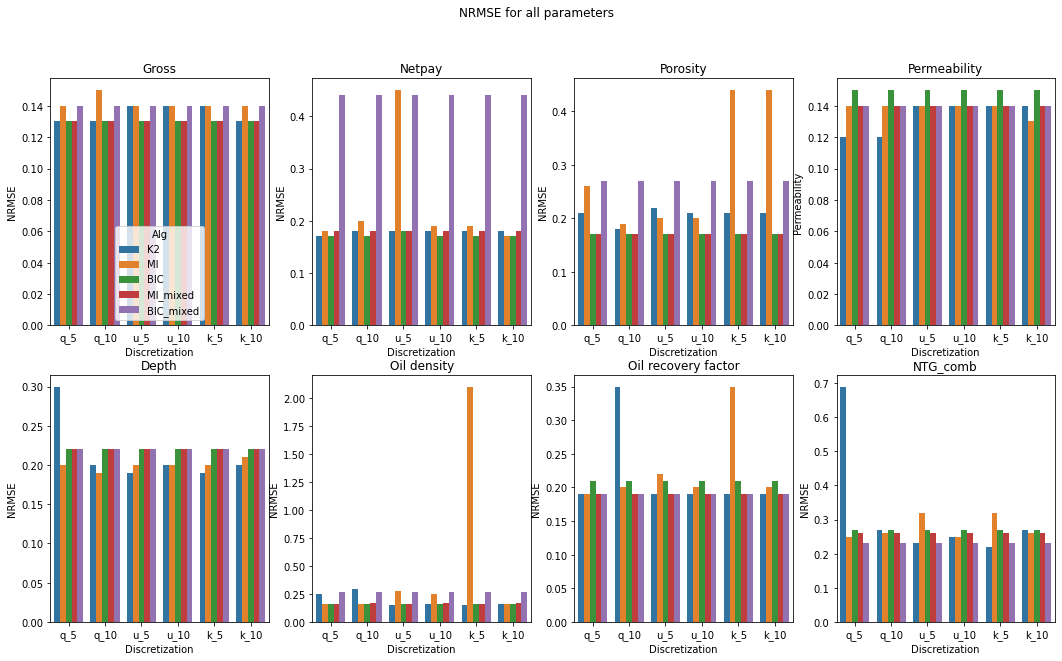

In [53]:
fig, axes = plt.subplots(2, 4, figsize=(18, 10))
fig.suptitle('NRMSE for all parameters')

# Bulbasaur
sns.barplot(ax=axes[0,0], x = 'Discretization', y = 'RMSE', hue = 'Alg', data=gross)
axes[0,0].set_ylabel('NRMSE')
axes[0,0].set_title('Gross')
sns.barplot(ax=axes[0,1], x = 'Discretization', y = 'RMSE', hue = 'Alg', data=netpay)
axes[0,1].set_ylabel('NRMSE')
axes[0,1].set_title('Netpay')
axes[0,1].get_legend().remove()
sns.barplot(ax=axes[0,2], x = 'Discretization', y = 'RMSE', hue = 'Alg', data=porosity)
axes[0,2].set_ylabel('NRMSE')
axes[0,2].set_title('Porosity')
axes[0,2].get_legend().remove()
sns.barplot(ax=axes[0,3], x = 'Discretization', y = 'RMSE', hue = 'Alg', data=permeability)
axes[0,3].set_ylabel('Permeability')
axes[0,3].set_title('Permeability')
axes[0,3].get_legend().remove()
sns.barplot(ax=axes[1,0], x = 'Discretization', y = 'RMSE', hue = 'Alg', data=depth)
axes[1,0].set_ylabel('NRMSE')
axes[1,0].set_title('Depth')
axes[1,0].get_legend().remove()
sns.barplot(ax=axes[1,1], x = 'Discretization', y = 'RMSE', hue = 'Alg', data=density)
axes[1,1].get_legend().remove()
axes[1,1].set_title('Oil density')
axes[1,1].set_ylabel('NRMSE')
sns.barplot(ax=axes[1,2], x = 'Discretization', y = 'RMSE', hue = 'Alg', data=factor)
axes[1,2].set_ylabel('NRMSE')
axes[1,2].set_title('Oil recovery factor')
axes[1,2].get_legend().remove()
sns.barplot(ax=axes[1,3], x = 'Discretization', y = 'RMSE', hue = 'Alg', data=ntg)
axes[1,3].set_ylabel('NRMSE')
axes[1,3].set_title('NTG_comb')
axes[1,3].get_legend().remove()


In [54]:
tec = results_acc.loc[results_acc['Parameter'] == 'Tectonic regime']
per = results_acc.loc[results_acc['Parameter'] == 'Period']
struct = results_acc.loc[results_acc['Parameter'] == 'Structural setting']
lyth = results_acc.loc[results_acc['Parameter'] == 'Lithology']

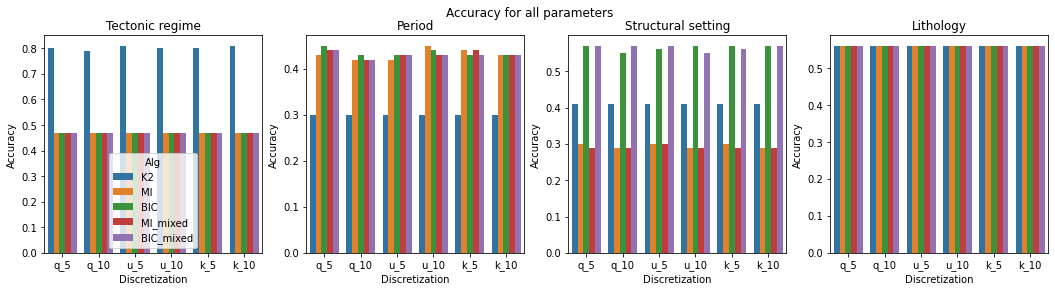

In [58]:
fig, axes = plt.subplots(1, 4, figsize=(18, 5))
fig.suptitle('Accuracy for all parameters')


sns.barplot(ax=axes[0], x = 'Discretization', y = 'Accuracy', hue = 'Alg', data=tec)
axes[0].set_title('Tectonic regime')
sns.barplot(ax=axes[1], x = 'Discretization', y = 'Accuracy', hue = 'Alg', data=per)
axes[1].set_title('Period')
axes[1].get_legend().remove()
sns.barplot(ax=axes[2], x = 'Discretization', y = 'Accuracy', hue = 'Alg', data=struct)
axes[2].set_title('Structural setting')
axes[2].get_legend().remove()
sns.barplot(ax=axes[3], x = 'Discretization', y = 'Accuracy', hue = 'Alg', data=lyth)
axes[3].set_title('Lithology')
axes[3].get_legend().remove()

In [59]:
results_rmse.groupby('Kind')['RMSE'].mean()

Kind
k_10 BIC          0.18500
k_10 BIC_mixed    0.23750
k_10 K2           0.18500
k_10 MI           0.21375
k_10 MI_mixed     0.18250
k_5 BIC           0.18500
k_5 BIC_mixed     0.23750
k_5 K2            0.17750
k_5 MI            0.48500
k_5 MI_mixed      0.18125
q_10 BIC          0.18500
q_10 BIC_mixed    0.23750
q_10 K2           0.21500
q_10 MI           0.18625
q_10 MI_mixed     0.18250
q_5 BIC           0.18500
q_5 BIC_mixed     0.23750
q_5 K2            0.25750
q_5 MI            0.19000
q_5 MI_mixed      0.18125
u_10 BIC          0.18500
u_10 BIC_mixed    0.23750
u_10 K2           0.18375
u_10 MI           0.19625
u_10 MI_mixed     0.18250
u_5 BIC           0.18625
u_5 BIC_mixed     0.23750
u_5 K2            0.18000
u_5 MI            0.24375
u_5 MI_mixed      0.18125
Name: RMSE, dtype: float64

In [26]:
results_acc["Kind"] = results_acc["Discretization"] + " "+ results_acc["Alg"]

In [62]:
results_acc.groupby('Kind')['Accuracy'].mean()

Kind
k_10 BIC          0.5075
k_10 BIC_mixed    0.5075
k_10 K2           0.5200
k_10 MI           0.4375
k_10 MI_mixed     0.4375
k_5 BIC           0.5075
k_5 BIC_mixed     0.5050
k_5 K2            0.5175
k_5 MI            0.4425
k_5 MI_mixed      0.4400
q_10 BIC          0.5025
q_10 BIC_mixed    0.5050
q_10 K2           0.5150
q_10 MI           0.4350
q_10 MI_mixed     0.4350
q_5 BIC           0.5125
q_5 BIC_mixed     0.5100
q_5 K2            0.5175
q_5 MI            0.4400
q_5 MI_mixed      0.4400
u_10 BIC          0.5100
u_10 BIC_mixed    0.5025
u_10 K2           0.5175
u_10 MI           0.4425
u_10 MI_mixed     0.4375
u_5 BIC           0.5050
u_5 BIC_mixed     0.5075
u_5 K2            0.5200
u_5 MI            0.4375
u_5 MI_mixed      0.4400
Name: Accuracy, dtype: float64

In [15]:
acc, rmse = LOO_validation(geo, geo_discrete, 'simple', columns, 'HC', 'K2', normed=False) 

  0%|          | 20/1000000 [00:05<82:47:25,  3.36it/s]
"['DEVONIAN-PERMIAN']"
"['DEVONIAN-PERMIAN']"
"['DEVONIAN-PERMIAN', 'LIMESTONE', 'SUB-SALT']"
  0%|          | 22/1000000 [00:06<83:41:48,  3.32it/s] 
"['PALEOGENE', 'PASSIVE MARGIN', 'SUBMARINE CANYON']"
  0%|          | 20/1000000 [00:05<76:45:46,  3.62it/s]
"['CARBONIFEROUS-CRETACEOUS']"
"['CARBONIFEROUS-CRETACEOUS']"
  0%|          | 22/1000000 [00:06<82:52:37,  3.35it/s]
"['JURASSIC', 'FORELAND', 'LACUSTRINE DELTA']"
  0%|          | 20/1000000 [00:05<77:28:14,  3.59it/s]
"['INVERSION', 'PELAGIC']"
  0%|          | 7/1000000 [00:00<35:30:52,  7.82it/s]


KeyboardInterrupt: 

In [149]:
acc, rmse, real, pred = calculate_acc(all_bn, test, ['Oil recovery factor'], 'simple', normed=False)

In [150]:
rmse

{'Oil recovery factor': 0.14}

In [61]:
target_unit = {'Lithology':'SANDSTONE', 'Period': 'JURASSIC', 'Structural setting': 'WRENCH', 'Gross': 160, 'Netpay': 120, 'Permeability': 221, 'Porosity': 17, 'Depth': 1566, 'Oil density': 815.5, 'NTG_comb':0.76}

In [62]:
sample_cosine = get_subsample(target_unit, data, 'cosine', ['Lithology', 'Period', 'Structural setting', 'Gross', 'Netpay', 'Permeability', 'Porosity', 'Depth', 'Oil density'], 60)
sample_cosine.reset_index(inplace=True, drop=True)

In [63]:
sample_gower = get_subsample(target_unit, data, 'gower', ['Lithology', 'Period', 'Structural setting', 'Gross', 'Netpay', 'Permeability', 'Porosity', 'Depth', 'Oil density'], 60)
sample_gower.reset_index(inplace=True, drop=True)

In [181]:
sample_coded, label_coder = code_categories(sample, 'label', colums_for_code)
sample_discrete, coder = discretization(sample_coded, 'equal_frequency', columns_for_disc)

In [182]:
bn_full = structure_learning(sample_discrete, 'HC', geo_types, 'K2')

  0%|          | 15/1000000 [00:01<33:36:38,  8.26it/s]


In [122]:
params = parameter_learning(sample, geo_types, bn_full, 'simple')
save_structure(bn_full, 'all_net')
skel = read_structure('all_net')
save_params(params, 'all_net_param')
params = read_params('all_net_param')
all_bn = HyBayesianNetwork(skel, params)

In [64]:
sample_rv = generate_synthetics(all_bn, geo_signs, 'simple', 2000, target_unit)

In [65]:
sample_rv['Oil recovery factor'].mean()

0.37287324131681376